In [177]:
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from qc_grader.graph_util import display_maxcut_widget, QAOA_widget, graphs
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit_optimization import QuadraticProgram
from typing import List
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from time import time
from copy import copy
from qc_grader.graph_util import display_maxcut_widget, QAOA_widget, graphs
import math
from qiskit.visualization import plot_histogram
import operator


matplotlib.rcParams['figure.dpi'] = 100

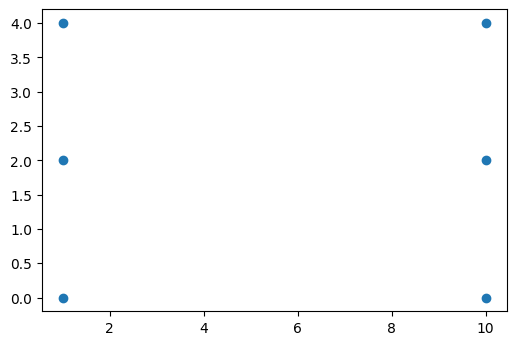

In [148]:
X = np.array([[1, 2], [1, 4], [1, 0],
            [10, 2], [10, 4], [10, 0]])
plt.scatter(X[:,0], X[:,1])

In [149]:
### Each point has an id
def get_points_dict(X):
    points = {}
    i = 0
    for p in X:
        points[i] = p
        i += 1
    num_points = i - 1
    return points

In [150]:
points = get_points_dict(X)

### Classical K-means

In [151]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

array([1, 1, 1, 0, 0, 0], dtype=int32)

In [152]:
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(X)

Text(0.5, 1.0, 'Classical Prediction')

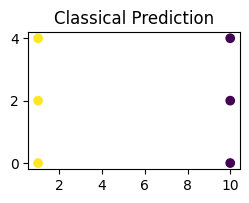

In [153]:
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Classical Prediction")

### Quantum K-means

#### Generate a graph from the points in the array

Each vertex representing a point on x-y plane and weights between the vertices is the distance between them

In [154]:
def graph_from_points(points):
    num_points = len(points)
    G = nx.Graph()
    edges = []
    for i in range(num_points):
        G.add_node(i, pos=tuple(points[i]))
        for j in range(num_points):
            if i == j: 
                continue
            edges.append((i, j, np.linalg.norm(points[i] - points[j])))

    G.add_weighted_edges_from(edges)
    return G

In [155]:
G = graph_from_points(points)

In [156]:
pos=nx.get_node_attributes(G,'pos')
labels = nx.get_edge_attributes(G,'weight')

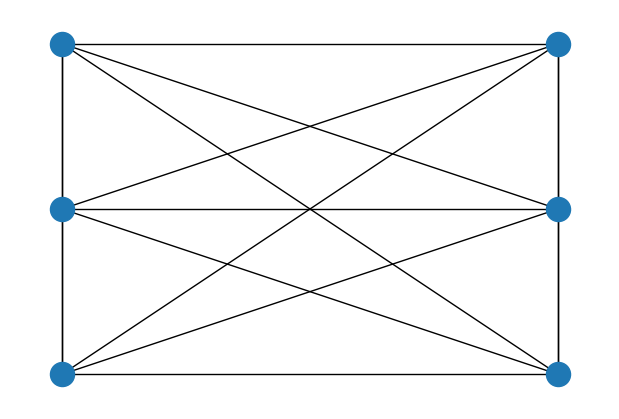

In [157]:
nx.draw(G,pos)

In [158]:
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [159]:
def maxcut_cost_fn(graph: nx.Graph, bitstring: List[int]) -> float:
    """
    Computes the maxcut cost function value for a given graph and cut represented by some bitstring
    Args:
        graph: The graph to compute cut values for
        bitstring: A list of integer values '0' or '1' specifying a cut of the graph
    Returns:
        The value of the cut
    """
    #Get the weight matrix of the graph
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    size = weight_matrix.shape[0]
    value = 0.

    #INSERT YOUR CODE TO COMPUTE THE CUT VALUE HERE
    set_zero = []
    set_one = []
    for i, bit_value in enumerate(bitstring):
        if (bit_value == 0):
            set_zero.append(i)
        else:
            set_one.append(i)
    for i in set_zero:
        for j in set_one:
            value += weight_matrix[i, j]
    return value

def plot_maxcut_histogram(graph: nx.Graph) -> None:
    """
    Plots a bar diagram with the values for all possible cuts of a given graph.
    Args:
        graph: The graph to compute cut values for
    """
    num_vars = graph.number_of_nodes()
    #Create list of bitstrings and corresponding cut values
    bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
    values = [maxcut_cost_fn(graph = graph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
    #Sort both lists by largest cut value
    values, bitstrings = zip(*sorted(zip(values, bitstrings)))
    #Plot bar diagram
    bar_plot = go.Bar(x = bitstrings, y = values, marker=dict(color=values, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
    fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1500, height = 600))
    fig.show()

In [160]:
plot_maxcut_histogram(G)

In [161]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    """Constructs a quadratic program from a given graph for a MaxCut problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]

    #INSERT YOUR CODE HERE
    quadratic_program = QuadraticProgram('')
    for i in range(size):
        name = 'x_' + str(i)
        quadratic_program.binary_var(name = name)
#     print(qubo_vector)
    quadratic_program.maximize(quadratic = qubo_matrix, linear = qubo_vector.T, constant=0)
    
    
    return quadratic_program

In [162]:
quadratic_program = quadratic_program_from_graph(G)
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: 31.439088914586 x_0 + 34.068402259089 x_1 + 34.068402259089 x_2
      + 31.439088914586 x_3 + 34.068402259089 x_4 + 34.068402259089 x_5 + [
      - 8 x_0*x_1 - 8 x_0*x_2 - 36 x_0*x_3 - 36.878177829172 x_0*x_4
      - 36.878177829172 x_0*x_5 - 16 x_1*x_2 - 36.878177829172 x_1*x_3
      - 36 x_1*x_4 - 39.395431207184 x_1*x_5 - 36.878177829172 x_2*x_3
      - 39.395431207184 x_2*x_4 - 36 x_2*x_5 - 8 x_3*x_4 - 8 x_3*x_5
      - 16 x_4*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [163]:
def qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    #Outer loop to create each layer
    for i in range(p):

        #Apply R_Z rotational gates from cost layer
        #INSERT YOUR CODE HERE
        # The rz gates below can be commented out as well. As mentioned above, for Maxcut, single rz gate angle is 0.
        for j in range(size):
            qaoa_circuit.rz((qubo_linearity[j] + sum(qubo_matrix[j]))*1.0*gammas[i], j)

        #Apply R_ZZ rotational gates for entangled qubit rotations from cost layer
        #INSERT YOUR CODE HERE
        for j in range(size):
            for k in range(size):
                if (j == k):
                    continue
                qaoa_circuit.rzz(0.5*qubo_matrix[j,k]*gammas[i], j, k)

        # Apply single qubit X - rotations with angle 2*beta_i to all qubits
        #INSERT YOUR CODE HERE
        for j in range(size):
            qaoa_circuit.rx(2.*betas[i], j)

    return qaoa_circuit

In [164]:
quadratic_program = quadratic_program_from_graph(G)
custom_circuit = qaoa_circuit(qubo = quadratic_program)

In [165]:
custom_circuit.draw()

┌───┐┌─────────┐                                        »
q_0: ┤ H ├┤ Rz(0.0) ├─■───────────────────■──────────────────»
     ├───┤├─────────┤ │ZZ(-1.0*gamma[0])  │                  »
q_1: ┤ H ├┤ Rz(0.0) ├─■───────────────────┼──────────────────»
     ├───┤├─────────┤                     │ZZ(-1.0*gamma[0]) »
q_2: ┤ H ├┤ Rz(0.0) ├─────────────────────■──────────────────»
     ├───┤├─────────┤                                        »
q_3: ┤ H ├┤ Rz(0.0) ├────────────────────────────────────────»
     ├───┤├─────────┤                                        »
q_4: ┤ H ├┤ Rz(0.0) ├────────────────────────────────────────»
     ├───┤├─────────┤                                        »
q_5: ┤ H ├┤ Rz(0.0) ├────────────────────────────────────────»
     └───┘└─────────┘                                        »
c: 6/════════════════════════════════════════════════════════»
                                                             »
«                                                          »
«q_0: ─■───────────────────■───────────────────────────────»
«      │                   │                               »
«q_1: ─┼───────────────────┼───────────────────────────────»
«      │                   │                               »
«q_2: ─┼───────────────────┼───────────────────────────────»
«      │ZZ(-4.5*gamma[0])  │                               »
«q_3: ─■───────────────────┼───────────────────────────────»
«                          │ZZ(-4.60977222864644*gamma[0]) »
«q_4: ─────────────────────■───────────────────────────────»
«                                                          »
«q_5: ─────────────────────────────────────────────────────»
«                                                          »
«c: 6/═════════════════════════════════════════════════════»
«                                                          »
«                                                                              »
«q_0: ─■────────────────────────────────■──────────────────────────────────────»
«      │                                │ZZ(-1.0*gamma[0])                     »
«q_1: ─┼────────────────────────────────■───────────────────■──────────────────»
«      │                                                    │ZZ(-2.0*gamma[0]) »
«q_2: ─┼────────────────────────────────────────────────────■──────────────────»
«      │                                                                       »
«q_3: ─┼───────────────────────────────────────────────────────────────────────»
«      │                                                                       »
«q_4: ─┼───────────────────────────────────────────────────────────────────────»
«      │ZZ(-4.60977222864644*gamma[0])                                         »
«q_5: ─■───────────────────────────────────────────────────────────────────────»
«                                                                              »
«c: 6/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                              »
«q_0: ──────────────────────────────────■──────────────────────────────────────»
«                                       │                                      »
«q_1: ─■────────────────────────────────┼───────────────────■──────────────────»
«      │                                │ZZ(-1.0*gamma[0])  │                  »
«q_2: ─┼────────────────────────────────■───────────────────┼──────────────────»
«      │ZZ(-4.60977222864644*gamma[0])                      │                  »
«q_3: ─■────────────────────────────────────────────────────┼──────────────────»
«                                                           │ZZ(-4.5*gamma[0]) »
«q_4: ──────────────────────────────────────────────────────■──────────────────»
«                                                                              »
«q_5: ─────────────────────────────────

In [166]:
def get_qoao_result(G, simulator='statevector_simulator'):
    backend = Aer.get_backend(simulator)
    qaoa = QAOA(optimizer = ADAM(), quantum_instance = backend, reps=1, initial_point = [0.1,0.1])
    eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
    quadratic_program = quadratic_program_from_graph(G)
    print("succesfully created a quadratic program")
    start_time = time()
    result = eigen_optimizer.solve(quadratic_program)
    end_time = time()
    print("Time taken: ", end_time - start_time)
    print(result)
    return result

In [113]:
result = get_qoao_result(G)

succesfully created a quadratic program
Time taken:  3.998422622680664
optimal function value: 83.57589343276376
optimal value: [1. 1. 1. 0. 0. 0.]
status: SUCCESS


Text(0.5, 1.0, 'Quantum Prediction')

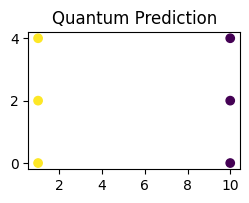

In [114]:
y_pred = result.x
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Quantum Prediction")

### Performance on Blobs dataset - 2 centers

In [115]:
from sklearn.datasets import make_blobs

In [116]:
n_samples = 10
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=2)

Text(0.5, 1.0, 'Classical K-means')

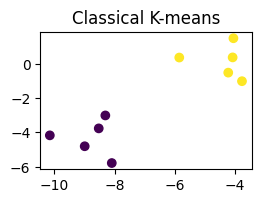

In [117]:
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Classical K-means")

### Quantum K-means

succesfully created a quadratic program
Time taken:  24.36424684524536
optimal function value: 159.50110583469316
optimal value: [0. 0. 1. 0. 1. 0. 1. 1. 1. 0.]
status: SUCCESS


Text(0.5, 1.0, 'Quantum Prediction')

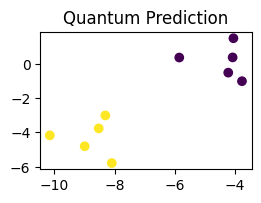

In [118]:
points = get_points_dict(X)
G = graph_from_points(points)
result = get_qoao_result(G, simulator='statevector_simulator')
y_pred = result.x
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Quantum Prediction")

### Performance on blobs dataset - 3 centers

In [119]:
n_samples = 10
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=3)

Text(0.5, 1.0, 'Incorrect Number of Blobs')

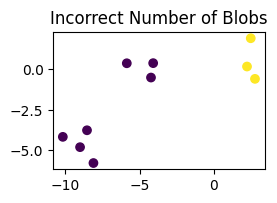

In [120]:
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

Text(0.5, 1.0, 'Correct Number of Blobs')

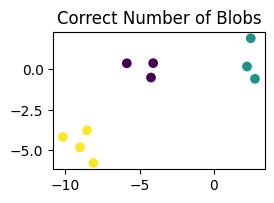

In [121]:
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Correct Number of Blobs")

### Quantum Prediction

succesfully created a quadratic program
Time taken:  21.87635087966919
optimal function value: 233.18212870888854
optimal value: [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
status: SUCCESS


Text(0.5, 1.0, 'Quantum Prediction')

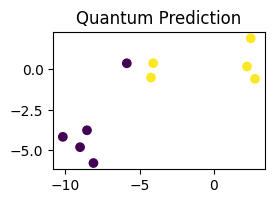

In [122]:
points = get_points_dict(X)
G = graph_from_points(points)
result = get_qoao_result(G, simulator='statevector_simulator')
y_pred = result.x
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Quantum Prediction")